In [111]:
%load_ext autoreload
%autoreload 2
import os

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1
import functools
import jax
# jax.config.update("jax_enable_x64", True)

import mujoco
from mujoco import mjx

from dm_control import mjcf
from dm_control.locomotion.walkers import rescale
from dm_control.mujoco.wrapper.mjbindings import enums
from typing import Dict
from brax import envs
import mujoco
import pickle
import warnings
import mediapy as media
import hydra
import h5py
import jax.numpy as jp
import numpy as np 
import matplotlib.pyplot as plt
from typing import List, Union
from pathlib import Path
from omegaconf import DictConfig, OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm
import brax.math as brax_math
warnings.filterwarnings("ignore", category=DeprecationWarning)
# jax.config.update("jax_enable_x64", True)

from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from pathlib import Path

import time
import mediapy as media

from IPython.display import clear_output
clear_output()

In [92]:
mjcf_path = './models/arm_model_v3_torque.xml'
mjcf_element = mjcf.from_path(mjcf_path)
physics = mjcf.Physics.from_mjcf_model(mjcf_element)
mj_data = mujoco.MjData(physics.model.ptr)

In [93]:
for i in range(10):
    for j in range(20):
        a = physics.model.id2name(i, j)
        if a: print(f'{i, j} {a}')

(0, 1) world
(0, 2) world
(0, 3) sh_elv
(0, 5) target
(0, 6) Pec_C_Origin
(0, 7) my_camera
(0, 8) //unnamed_light_0
(0, 10) Bone_Scapula_right_v3
(0, 13) //unnamed_texture_0
(0, 14) target
(0, 19) sh_elv_act
(1, 1) ground
(1, 2) ground
(1, 3) sh_extension
(1, 5) //unnamed_geom_1
(1, 6) AD_Origin
(1, 7) my_camera1
(1, 10) Bone_Humerus_right_v3
(1, 13) grid
(1, 14) grid
(1, 19) sh_extension_act
(2, 1) clavicle
(2, 2) clavicle
(2, 3) sh_rotation
(2, 5) //unnamed_geom_2
(2, 6) Lat_Origin
(2, 10) Bone_Clavicle_right_v3
(2, 19) sh_rotation_act
(3, 1) scapula
(3, 2) scapula
(3, 3) elbow
(3, 5) //unnamed_geom_3
(3, 6) PD_Origin
(3, 10) Bone_Ulna_right_v3
(3, 19) elbow_act
(4, 1) humerus
(4, 2) humerus
(4, 5) //unnamed_geom_4
(4, 6) MD_Origin
(4, 10) Bone_Radius_right_v3
(5, 1) ulna
(5, 2) ulna
(5, 5) elbow_marker
(5, 6) Triceps_Long_Origin
(5, 10) Bone_Segments_Hand
(6, 1) radius
(6, 2) radius
(6, 5) //unnamed_geom_6
(6, 6) Biceps_Long_Origin
(7, 1) hand
(7, 2) hand
(7, 5) //unnamed_geom_7
(7,

In [94]:
print(physics.model.name2id("hand", "body"))
print(physics.model.name2id("scapula", "body"))
print(physics.model.name2id("elbow_marker", "geom"))

7
3
5


In [95]:
physics.named.model.body_pos
# physics.named.model.geom_pos
# physics.named.model.site_pos

FieldIndexer(body_pos):
             x         y         z         
0    world [ 0         0         0       ]
1   ground [ 0         0         0       ]
2 clavicle [ 0         0         0       ]
3  scapula [-0.0001   -0.0001    0.0005  ]
4  humerus [ 0         0.0007   -0.0002  ]
5     ulna [-0.0005    0.0003   -0.0068  ]
6   radius [ 0.00035   0.0002    0.0002  ]
7     hand [ 0.003     0.0005   -0.009   ]

### Get the positions of hand, elbow, and scapula with dm_control mujoco

In [ ]:
# step forward in the model
mujoco.mj_kinematics(physics.model.ptr, mj_data)

# get coordinates of the model
scapula_idx = physics.model.name2id('scapula', 'body')
scapula_pos = physics.data.xpos[scapula_idx]

elbow_idx = physics.model.name2id('elbow_marker', 'geom')
elbow_pos = physics.data.geom_xpos[5]

hand_idx = physics.model.name2id('hand', 'body')
hand_pos = physics.data.xpos[hand_idx]

mujoco_arm_coords = np.concatenate([scapula_pos, elbow_pos, hand_pos]).reshape(-1, 3)
mujoco_arm_coords.shape

(3, 3)

In [109]:
with h5py.File("./tests/data/points3d_transformed_shorten.h5", 'r') as f:
    sleap_coords = f["tracks"][0][0]

In [110]:
# mujoco_arm_coords
sleap_coords

array([[-6.11255223, 10.60458006, 13.56400908],
       [-8.81604535, 11.9665426 ,  5.03752033],
       [ 1.26819147,  8.95696416,  3.92618692]])

In [136]:
mujoco_arm_coords

array([[-0.0001    , -0.0001    ,  0.0005    ],
       [ 0.0011889 , -0.00413805, -0.00495372],
       [ 0.0064878 , -0.01083974, -0.00897384]])

In [122]:
def plot_plane_and_points(points, fig=None, ax=None, color='r', label=''):
    """
    Plot the plane and the 3D points.
    
    Args:
        points (jax.numpy.ndarray): Array of shape (N, 3), the 3D points.
    """
    print('points',points.shape)
    
    # Compute the centroid of the points
    centroid = jp.mean(points, axis=0)
    
    # Center the points around the centroid
    centered_points = points - centroid
    
    # Compute the SVD of the centered points
    _, _, vh = jp.linalg.svd(centered_points, full_matrices=False)
    
    # The plane's normal is the singular vector corresponding to the smallest singular value
    normal = vh[-1]
    
    # Compute the intercept term (d) for the plane equation ax + by + cz + d = 0
    d = -jp.dot(normal, centroid)
    
    # Create a mesh grid for the plane
    x = jp.linspace(points[:, 0].min(), points[:, 0].max(), 10)
    y = jp.linspace(points[:, 1].min(), points[:, 1].max(), 10)
    x, y = jp.meshgrid(x, y)
    
    # Compute the corresponding z values for the plane equation ax + by + cz + d = 0
    z = (-normal[0] * x - normal[1] * y - d) / normal[2]
    
    # Plot the points and the plane
    if fig is None and ax is None:
        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_subplot(111, projection='3d')
    
    # Plot the points
    ax.scatter(points[0, 0], points[0, 1], points[0, 2], c='r', label=label+' Points')
    ax.scatter(points[1, 0], points[1, 1], points[1, 2], c='g', label=label+' Points')
    ax.scatter(points[2, 0], points[2, 1], points[2, 2], c='b', label=label+' Points')

    # Plot the plane
    ax.plot_surface(x, y, z, alpha=0.5, color=color, label=label + ' Plane')
    # ax.plot_surface(x, y, -.13*jp.ones_like(x), alpha=0.5, color='black', label='Ground Plane')
    
    # Set labels and title
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title("Fitted Plane and 3D Points")
    # ax.legend()

points (3, 3)


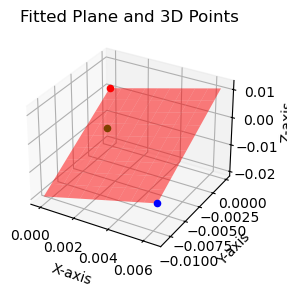

In [123]:
plot_plane_and_points(mujoco_arm_coords)

points (3, 3)


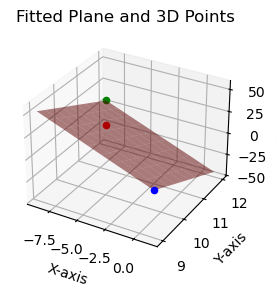

In [124]:
plot_plane_and_points(sleap_coords)

In [125]:
def procrustes_jax(source_points, target_points, floor=None):
    """
    Perform Procrustes analysis to align matrix source_points to matrix target_points.
    
    Parameters:
    source_points : (N, M) array_like
        The source input matrix.
    target_points : (N, M) array_like
        The reference/target input matrix.
    kp_idxs: (N,) array_like
        The indices of the keypoints to use for the alignment.
    floor : float, optional
    
    Returns:
    d : float
        The residual sum of squared errors.
    Z : (T,N, M) ndarray
        The matrix Y, transformed to best match X.
    R : (M, M) ndarray
        The rotation applied to Y.
    scale : float
        The scaling factor applied to Y.
    """
    
    # Center both matrices
    source_centered = source_points - jp.mean(source_points, axis=0)
    target_centered = target_points - jp.mean(target_points, axis=0)

    # Normalize the Frobenius norm to 1
    target_norm = jp.linalg.norm(target_centered)
    source_norm = jp.linalg.norm(source_centered)
    target_centered /= target_norm
    source_centered /= source_norm

    # Compute the optimal rotation matrix using Singular Value Decomposition (SVD) for the first frame
    U, _, Vt = jp.linalg.svd(jp.dot(target_centered.T, source_centered).T)
    R = jp.dot(U, Vt)

    # Apply the rotation and scaling to all frames
    scale = target_norm / source_norm
    Z = jp.dot(source_points, R) * scale
    d = jp.sum(jp.square(target_centered - Z))

    return d, Z, R, scale

In [126]:
d, Z, R, scale = procrustes_jax(
    source_points=sleap_coords,
    target_points=mujoco_arm_coords)

points (3, 3)


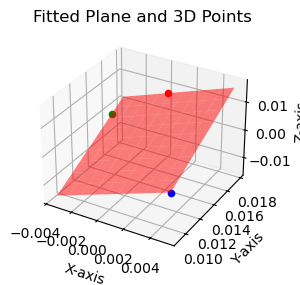

In [133]:
plot_plane_and_points(Z)

### Get the positions of hand, elbow, and scapula with dm_control mujoco + mjx

In [139]:
mjx_model = mjx.put_model(physics.model.ptr)
mjx_data = mjx.make_data(mjx_model)
mjx_data = mjx.kinematics(mjx_model, mjx_data)
mjx_data = mjx.com_pos(mjx_model, mjx_data)

In [148]:
print("frobenius norm of the matrices whose data points are the arm bodies: \n(comparing mjx vs mujoco)")
print(jp.linalg.norm(mjx_data.xpos - physics.data.xpos))


frobenius norm of the matrices whose data points are the arm bodies: 
(comparing mjx vs mujoco)
4.402599e-09


In [144]:
physics.data.xpos

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.00000000e-04, -1.00000000e-04,  5.00000000e-04],
       [-4.82361910e-05,  4.09625200e-04, -1.73032607e-05],
       [ 1.18889709e-03, -4.13804616e-03, -4.95371759e-03],
       [ 1.50802426e-03, -3.82079495e-03, -4.95063254e-03],
       [ 6.48780131e-03, -1.08397448e-02, -8.97383569e-03]])

In [ ]:
# todo1: apply the procustes alignment through the entire provided h5 dataset
# todo2: visualize the output
# todo3: implement to stac folder, submit pr